<a href="https://colab.research.google.com/github/baricio00/Health-Informatics-2025-26/blob/main/Lab_VI_SMHD_25_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<font size="6">Statistical Models for Healthcare Data</font>**

**<font size="5">MSc in Health Informatics - UniSR - A.Y. 2024-2025</font>**

Prof. Lara Cavinato - Dott. Vittorio Torri

---

<font size="4">Lab VI - Survival models</font>

# Libraries

In [ ]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpy as np

In [ ]:
np.random.seed(1234)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
!pip install lifelines

In [ ]:
!pip install scikit-survival

# Load Dataset

In [ ]:
from lifelines.datasets import load_lung
df = load_lung()

In [ ]:
df

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.00,306,1,74,1,1.00,90.00,100.00,1175.00,NaN
1,3.00,455,1,68,1,0.00,90.00,90.00,1225.00,15.00
2,3.00,1010,0,56,1,0.00,90.00,90.00,NaN,15.00
3,5.00,210,1,57,1,1.00,90.00,60.00,1150.00,11.00
4,1.00,883,1,60,1,0.00,100.00,90.00,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...
223,1.00,188,0,77,1,1.00,80.00,60.00,NaN,3.00
224,13.00,191,0,39,1,0.00,90.00,90.00,2350.00,-5.00
225,32.00,105,0,75,2,2.00,60.00,70.00,1025.00,5.00
226,6.00,174,0,66,1,1.00,90.00,100.00,1075.00,1.00


Data Source: Loprinzi CL. Laurie JA. Wieand HS. Krook JE. Novotny PJ. Kugler JW. Bartel J. Law M. Bateman M. Klatt NE. et al. Prospective evaluation of prognostic variables from patient-completed questionnaires. North Central Cancer Treatment Group. Journal of Clinical Oncology. 12(3):601–7, 1994.

The data consist of 228 observations related to patients with lung cancer. Each observation has 10 columns:

inst: Institution code

time: Survival time in days

status: censoring status 0 = censored, 1 = dead

age: Age in years

sex: Male = 1 Female = 2

ph.ecog: ECOG performance score as rated by the physician. 0 = asymptomatic, 1 = symptomatic but completely ambulatory, 2 = in bed <50% of the day, 3 = in bed > 50% of the day but not bed bound, 4 = bed bound

ph.karno: Karnofsky performance score (bad = 0; good = 100) rated by physician

pat.karno: Karnofsky performance score as rated by patient

meal.cal: Calories consumed at meals

wt.loss: Weight loss in last six months

## Missing values imputation

In [ ]:
df.isnull().sum()

,0
inst,1
time,0
status,0
age,0
sex,0
ph.ecog,1
ph.karno,1
pat.karno,3
meal.cal,47
wt.loss,14


Replace missing values of numerical columns with the mean value

In [ ]:
df["ph.karno"] = df["ph.karno"].fillna(df["ph.karno"].mean())
df["pat.karno"] = df["pat.karno"].fillna(df["pat.karno"].mean())
df["meal.cal"] = df["meal.cal"].fillna(df["meal.cal"].mean())
df["wt.loss"] = df["wt.loss"].fillna(df["wt.loss"].mean())

Replace missing categorical values with the mode (most frequent value)

In [ ]:
df["ph.ecog"] = df["ph.ecog"].fillna(df["ph.ecog"].mode()[0])
df["inst"] = df["inst"].fillna(df["inst"].mode()[0])

Map male to names

In [ ]:
df['sex'] = df['sex'].map({1: 'Male', 2: 'Female'})

## Description

In [ ]:
num_vars = ['age', 'ph.karno', 'pat.karno', 'meal.cal', 'wt.loss', 'time']
cat_vars = ['sex', 'ph.ecog', 'status', 'inst']

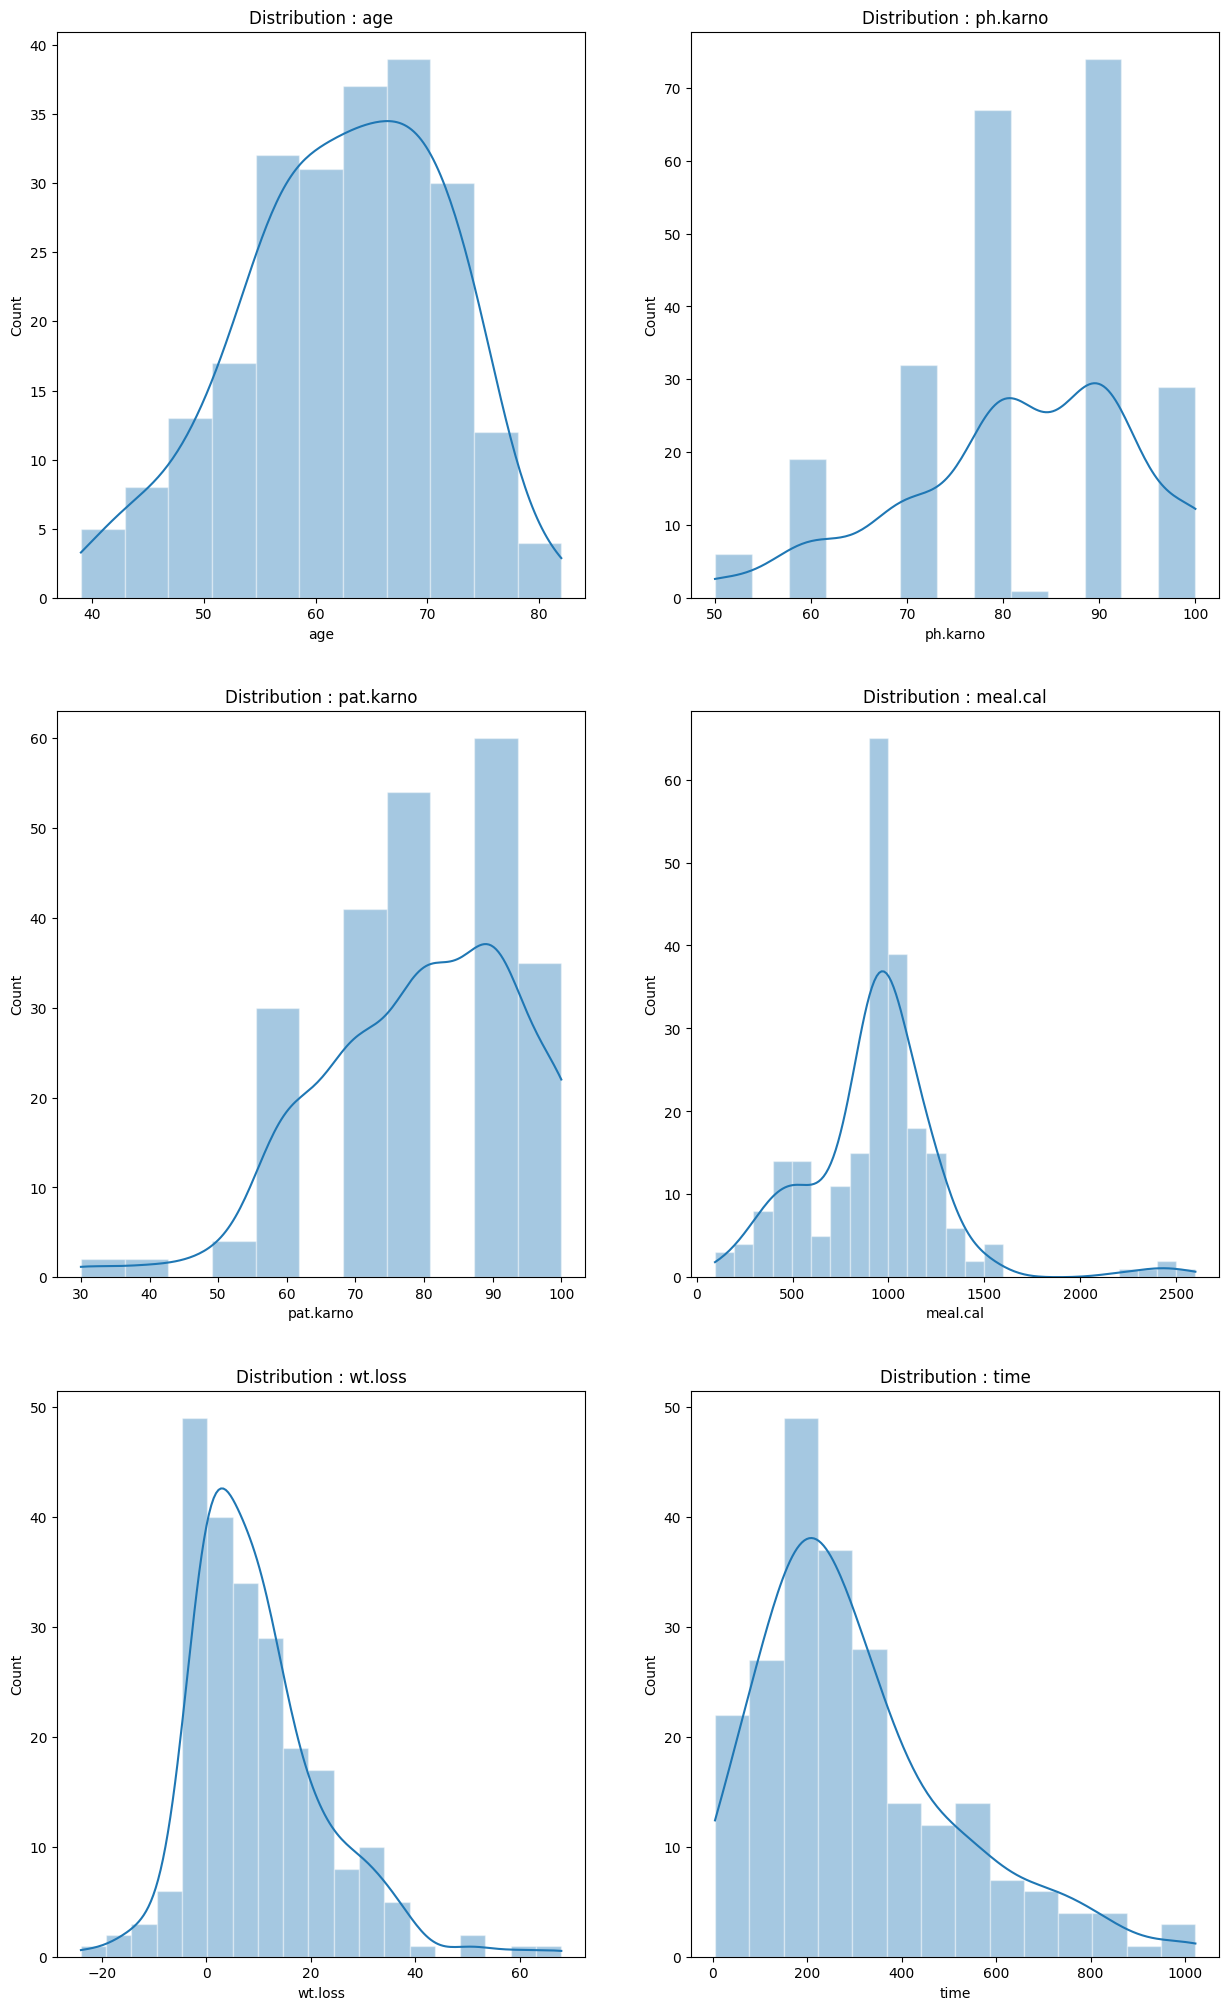

In [ ]:
nrows = 3
ncols = 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize = (15,25))
for i in range(len(num_vars)):
    plt.subplot(nrows,ncols,i+1)
    sns.histplot(
      data=df, x=num_vars[i], kde=True,
      alpha=.4, edgecolor=(1, 1, 1, .4)
    )
    title = 'Distribution : ' + num_vars[i]
    plt.title(title)
plt.show()

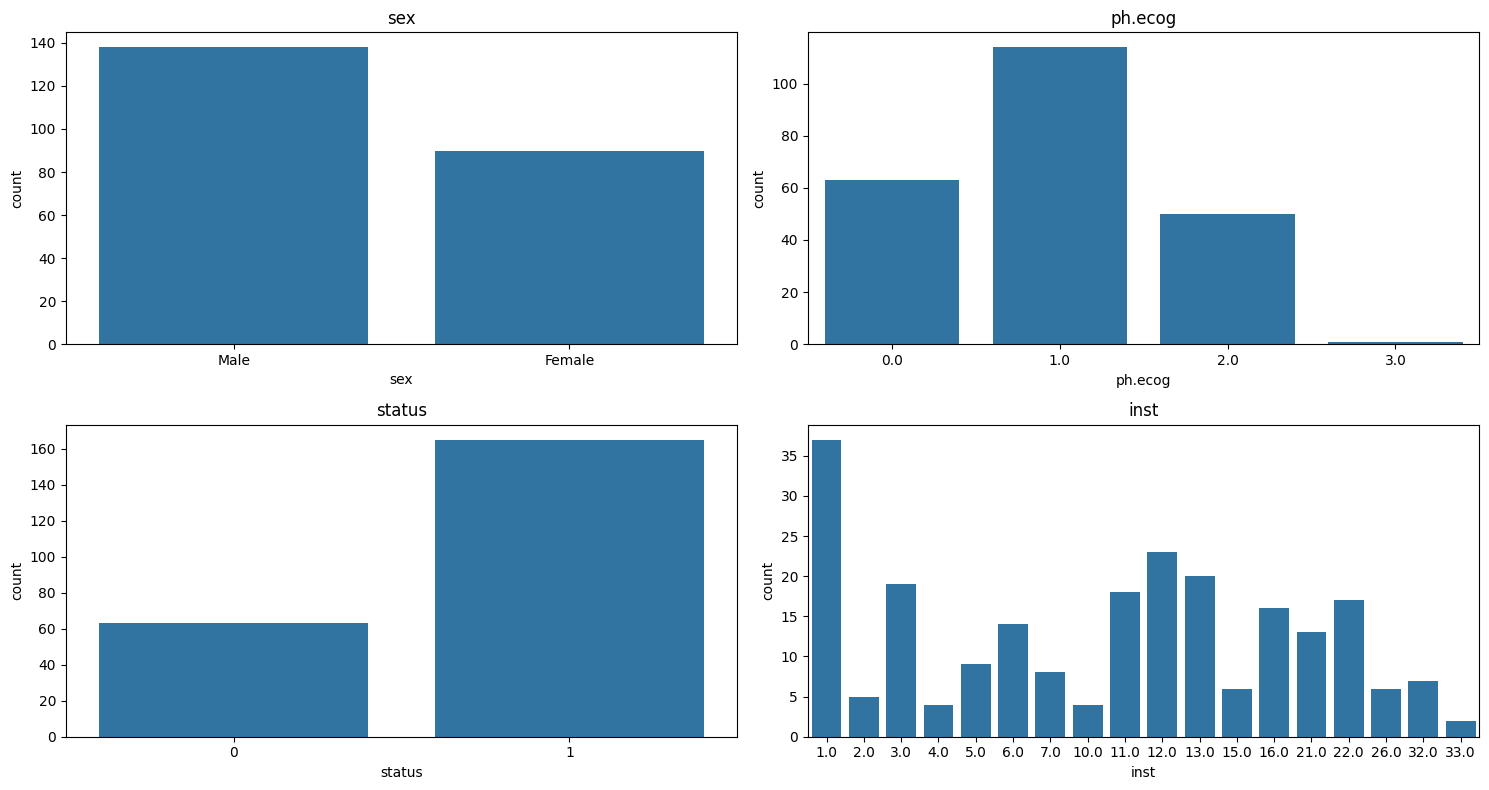

In [ ]:
fig, ax = plt.subplots(nrows = 2,ncols = 2,figsize = (15,8))

ax = ax.flatten()

for i in range(len(cat_vars)):
    sns.countplot(data=df, x=cat_vars[i], legend=False, ax=ax[i])
    title = cat_vars[i]
    ax[i].set_title(title)
plt.tight_layout()
plt.show()

# Kaplan-Maier Curves

$ S(t) = P(T > t) $ is the Survival function

A non-parametric estimate for $S(t)$ is the Kaplan-Meier estimator

$$\hat{S}(t) = \prod_{j: t_j* \leq t}(1-\frac{d_j}{n_j}) $$

where $d_j$ are the number of events observed at $t_j*$ and $n_j$ are the number of people at risk at $t_j*$

In [ ]:
from lifelines import KaplanMeierFitter

<Axes: title={'center': 'Survival function lung patients'}, xlabel='timeline'>

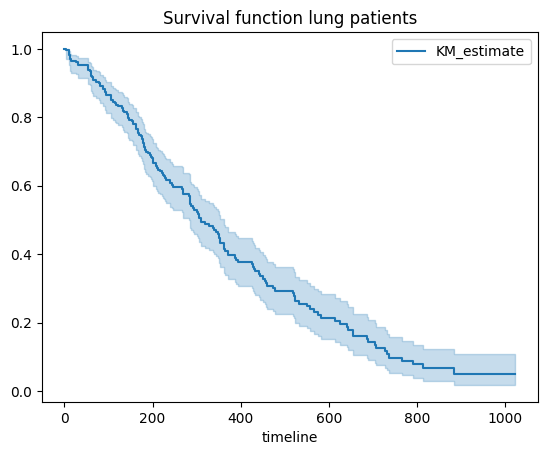

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df['time'], event_observed = df['status'])
kmf.plot(title='Survival function lung patients', ci_show=True)

It's a stepwise function with steps at the observed death times

Pointwise confidence intervals can be estimated (see Section 4.3 of Klein & Moeschberger)

In [ ]:
kmf.survival_function_

,KM_estimate
timeline,
0.00,1.00
5.00,1.00
11.00,0.98
12.00,0.98
13.00,0.97
...,...
840.00,0.07
883.00,0.05
965.00,0.05


In [ ]:
kmf.confidence_interval_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.00,1.00,1.00
5.00,0.97,1.00
11.00,0.95,0.99
12.00,0.95,0.99
13.00,0.94,0.99
...,...,...
840.00,0.03,0.12
883.00,0.02,0.11
965.00,0.02,0.11
1010.00,0.02,0.11


Median survival time (t s.t. S(t) = 0.50), with confidence intervals



In [ ]:
from lifelines.utils import median_survival_times

print('Meadian survival time:', kmf.median_survival_time_)
print('\n\n')
print(median_survival_times(kmf.confidence_interval_))

Meadian survival time: 310.0



      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.50                  284.00                  361.00


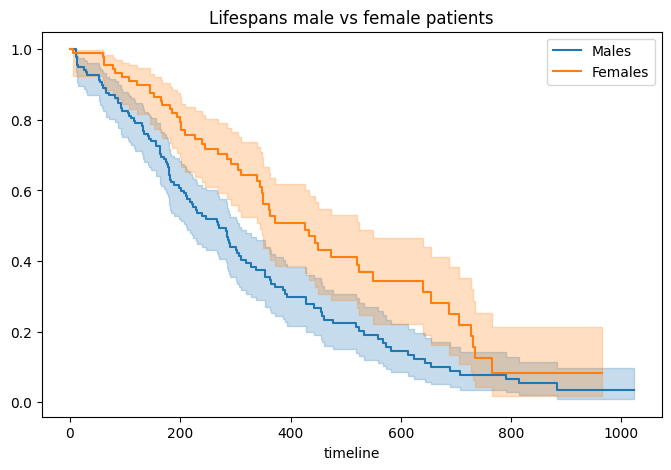

In [ ]:
# TODO: plot the kaplain maier estimates (with CI) of survival function for male and female patients
# Keep both on the same plot

fig, ax = plt.subplots(figsize=(8,5))

males = (df["sex"] == "Male")

kmf.fit(df.loc[males]['time'], event_observed=df.loc[males]['status'], label="Males")
kmf.plot_survival_function(ax=ax)

kmf.fit(df.loc[~males]['time'], event_observed=df.loc[~males]['status'], label="Females")
kmf.plot_survival_function(ax=ax)

plt.title("Lifespans male vs female patients");

In [ ]:
df.groupby('ph.ecog').size()

,0
ph.ecog,
0.00,63
1.00,114
2.00,50
3.00,1


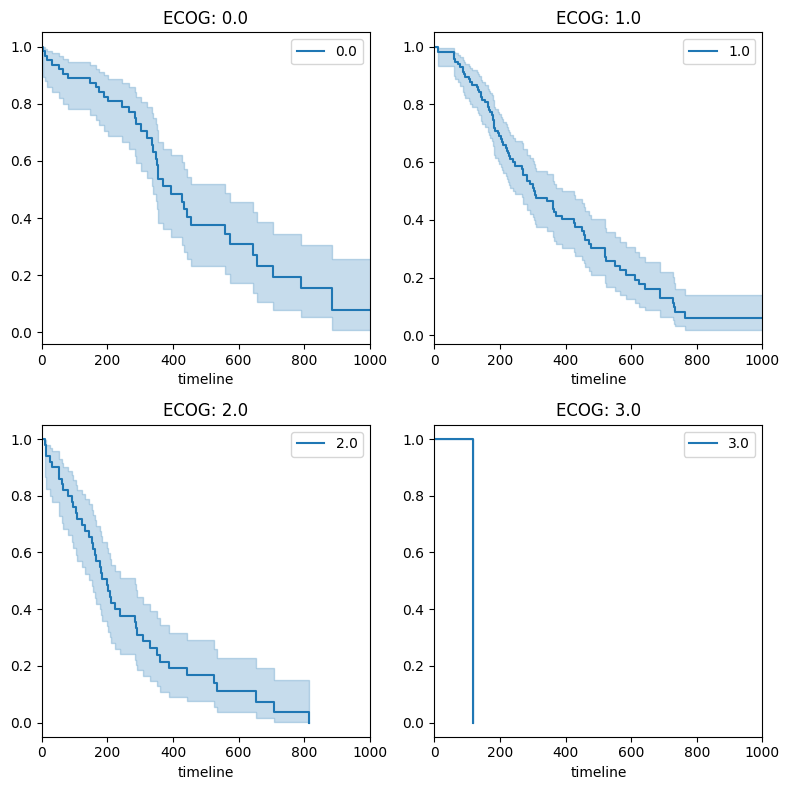

In [ ]:
# TODO plot the survival functions for the different values of ECOG
# Compare different plots vs a single plot with all of them

ecog_values = np.sort(df['ph.ecog'].unique())

plt.figure(figsize=(8,8))

for i, ecog in enumerate(ecog_values):
    ax = plt.subplot(2, 2, i+1)
    ix = df['ph.ecog'] == ecog
    kmf.fit(df.loc[ix]['time'], df.loc[ix]['status'], label=ecog)
    kmf.plot_survival_function(ax=ax, legend=True)

    plt.title('ECOG: ' + str(ecog))
    ax.set_xlim([0,1000])
plt.tight_layout()

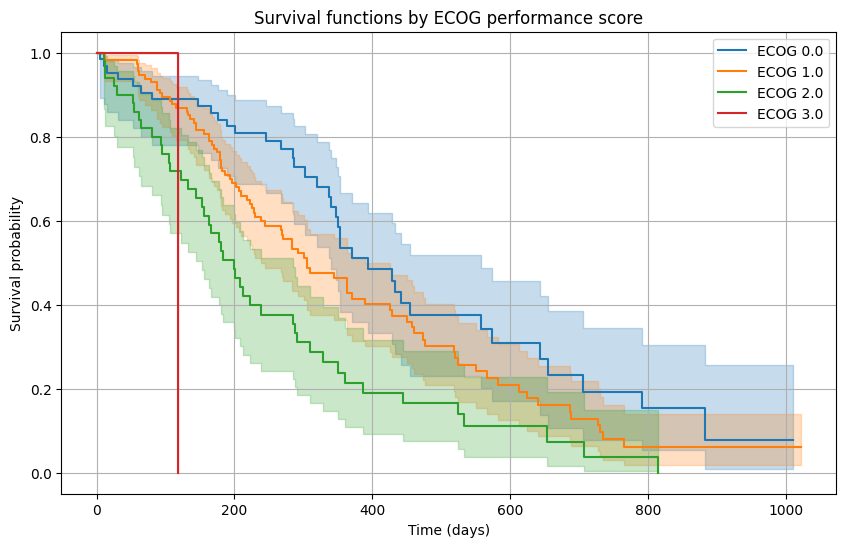

In [ ]:
plt.figure(figsize=(10, 6))
for ecog in ecog_values:
    ix = df['ph.ecog'] == ecog
    kmf.fit(df.loc[ix]['time'], df.loc[ix]['status'], label=f"ECOG {ecog}")
    kmf.plot_survival_function(ci_show=True)

plt.title('Survival functions by ECOG performance score')
plt.xlabel('Time (days)')
plt.ylabel('Survival probability')
plt.legend()
plt.grid(True)
plt.show()

KM including a table

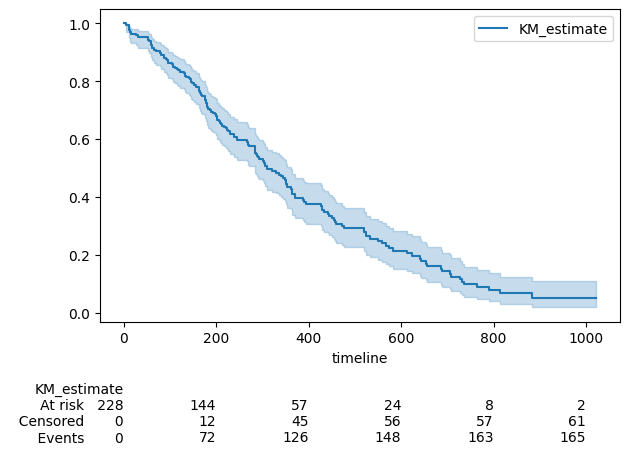

In [ ]:
kmf = KaplanMeierFitter().fit(df['time'], df['status'])
kmf.plot_survival_function(at_risk_counts=True)
plt.tight_layout()

In [ ]:
df[df.time > 1000]

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
2,3.00,1010,0,56,Male,0.00,90.00,90.00,928.78,15.00
5,12.00,1022,0,74,Male,1.00,50.00,80.00,513.00,0.00


# Nelson-Aalen estimation cumulative hazard function

Definition of the hazard function $h(t)$ and of the cumulative hazard function $H(t)$

$$ h(t) = \lim_{Δt → 0} \frac{P(t \leq T \leq t + \Delta t | T \geq t)}{Δ t} = \frac{-dlog(S(t))}{dt}$$
$$ H(t) = ∫_0^t h(u)du $$

$H(t)$ corresponds to the # of events that would be expected for each individual by time $t$ if the event were a repeatable process.

A non-parametric estimate of $H(t)$ can be derived from the KM estimate for S(t), but a better one is directly provided by the Nelson-Aalen estimator:

$$\hat{H}(t) = \sum_{j:t_j* \leq t} \frac{d_j}{n_j} $$

<Axes: xlabel='timeline'>

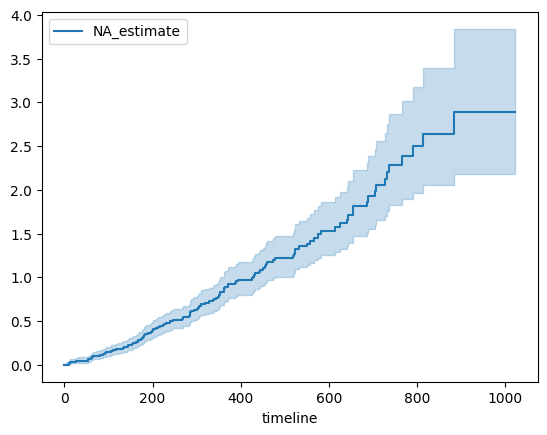

In [ ]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(df['time'],event_observed=df['status'])
naf.plot_cumulative_hazard()

In [ ]:
naf.cumulative_hazard_

,NA_estimate
timeline,
0.00,0.00
5.00,0.00
11.00,0.02
12.00,0.02
13.00,0.03
...,...
840.00,2.64
883.00,2.89
965.00,2.89


# Log-rank test

A test to compare survival curves of two populations (males and females):

$$H_0: S_1() = S_2()$$
$$H_1: S_1() \neq S_2()$$

In [ ]:
from lifelines.statistics import logrank_test

males = (df["sex"] == "Male")

T = df['time']
E = df['status']

results = logrank_test(T[males], T[~males], E[males], E[~males])

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.33 <0.005      9.57

It can also compare survival functions of K (>2) groups

$$H_0: S_1() = S_2() = ... = S_K()$$
$$H_1: \text{survival curves are different}$$

In [ ]:
df = df[df['ph.ecog'] != 3.0]

In [ ]:
from lifelines.statistics import multivariate_logrank_test

results = multivariate_logrank_test(df['time'], df['ph.ecog'], df['status'])
results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          17.80 <0.005     12.84

# Cox Model

A simple semi-parametric model for the hazard function

$$h_i(t) = h_0(t) \cdot exp(X_i^T \beta) $$

where $h_0(t)$ is called baseline hazard function, $X_i$ are the individual's covariates and $\beta$ their coefficients.

Hazard ratios:

$$HR_l = exp(\beta_l) $$

$= 1$ no effect

$> 1$ increases the hazard

$< 1$ decreases the hazard

## Model fitting

As usual, we need to one-hot encode categorical variables

In [ ]:
df_enc = pd.get_dummies(df, columns=['ph.ecog', 'sex', 'inst'], dtype=int, drop_first=True)

The institution has many possible values, with limited number of occurences for each value, and might create problems in the convergence of the fitting procedure

In [ ]:
df_enc

,time,status,age,ph.karno,pat.karno,meal.cal,wt.loss,ph.ecog_1.0,ph.ecog_2.0,sex_Male,...,inst_11.0,inst_12.0,inst_13.0,inst_15.0,inst_16.0,inst_21.0,inst_22.0,inst_26.0,inst_32.0,inst_33.0
0,306,1,74,90.00,100.00,1175.00,9.83,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,455,1,68,90.00,90.00,1225.00,15.00,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1010,0,56,90.00,90.00,928.78,15.00,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,210,1,57,90.00,60.00,1150.00,11.00,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,883,1,60,100.00,90.00,928.78,0.00,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,188,0,77,80.00,60.00,928.78,3.00,1,0,1,...,0,0,0,0,0,0,0,0,0,0
224,191,0,39,90.00,90.00,2350.00,-5.00,0,0,1,...,0,0,1,0,0,0,0,0,0,0
225,105,0,75,60.00,70.00,1025.00,5.00,0,1,0,...,0,0,0,0,0,0,0,0,1,0
226,174,0,66,90.00,100.00,1075.00,1.00,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_enc.columns

Index(['time', 'status', 'age', 'ph.karno', 'pat.karno', 'meal.cal', 'wt.loss',
       'ph.ecog_1.0', 'ph.ecog_2.0', 'sex_Male', 'inst_2.0', 'inst_3.0',
       'inst_4.0', 'inst_5.0', 'inst_6.0', 'inst_7.0', 'inst_10.0',
       'inst_11.0', 'inst_12.0', 'inst_13.0', 'inst_15.0', 'inst_16.0',
       'inst_21.0', 'inst_22.0', 'inst_26.0', 'inst_32.0', 'inst_33.0'],
      dtype='object')

In [ ]:
inst_cols = [col for col in df_enc.columns if col.startswith('inst')]
df_enc = df_enc.drop(columns=inst_cols)

In [ ]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(df_enc, duration_col = 'time', event_col = 'status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 227 total observations, 63 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 227
number of events observed = 164
   partial log-likelihood = -726.70
         time fit was run = 2025-11-25 10:21:10 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
age          0.01      1.01      0.01           -0.01            0.03                0.99                1.03
ph.karno     0.01      1.01      0.01           -0.00            0.03                1.00                1.03
pat.karno   -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
meal.cal     0.00      1.00      0.00           -0.00            0.00                1.00                1.00
wt.loss     -0.01      0.99      0.01           -0.02            0.00                0.98                1.00
ph.ecog_1.0  0.60      1.83      0.24            0.14            1.07                1.15                2.91
ph.ecog_2.0  1.13      3.10      0.37            0.40            1.86                1.49                6.44
sex_Male     0.58      1.79      0.17            0.25            0.92                1.28                2.51

             cmp to     z      p  -log2(p)
covariate                                 
age            0.00  1.29   0.20      2.35
ph.karno       0.00  1.46   0.14      2.79
pat.karno      0.00 -1.80   0.07      3.80
meal.cal       0.00  0.12   0.91      0.14
wt.loss        0.00 -1.61   0.11      3.22
ph.ecog_1.0    0.00  2.53   0.01      6.45
ph.ecog_2.0    0.00  3.03 <0.005      8.70
sex_Male       0.00  3.43 <0.005     10.67
---
Concordance = 0.65
Partial AIC = 1469.40
log-likelihood ratio test = 35.58 on 8 df
-log2(p) of ll-ratio test = 15.54

<Axes: xlabel='HR (95% CI)'>

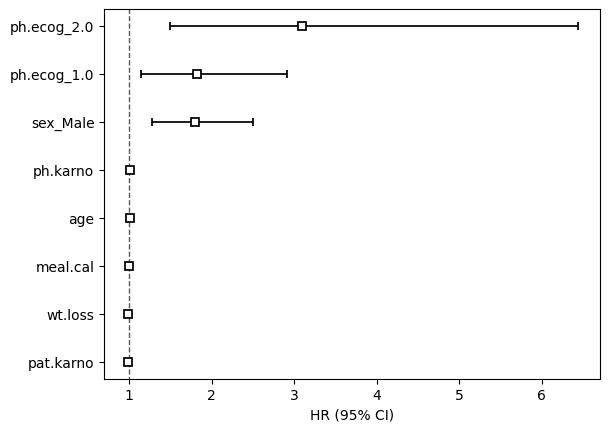

In [ ]:
cph.plot(hazard_ratios=True)

In [ ]:
cph.baseline_hazard_

,baseline hazard
5.00,0.00
11.00,0.01
12.00,0.00
13.00,0.01
15.00,0.00
...,...
840.00,0.00
883.00,0.31
965.00,0.00
1010.00,0.00


Let's look at $\hat{h}_0(t)$ and $\hat{H}_0(t)$

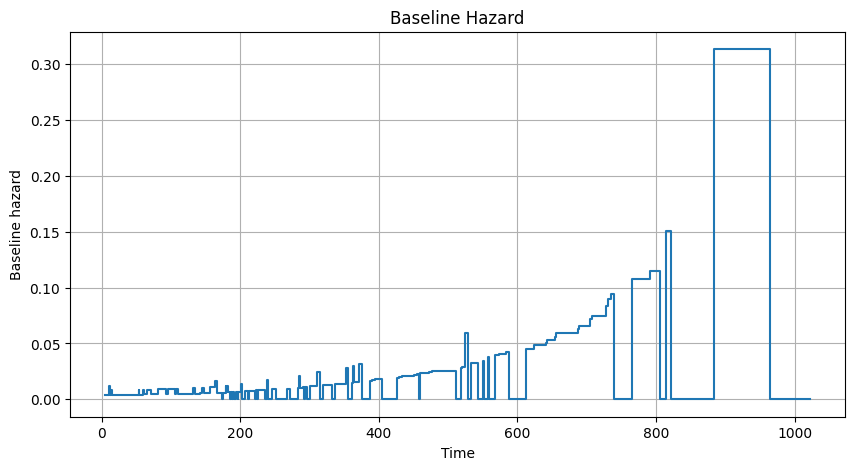

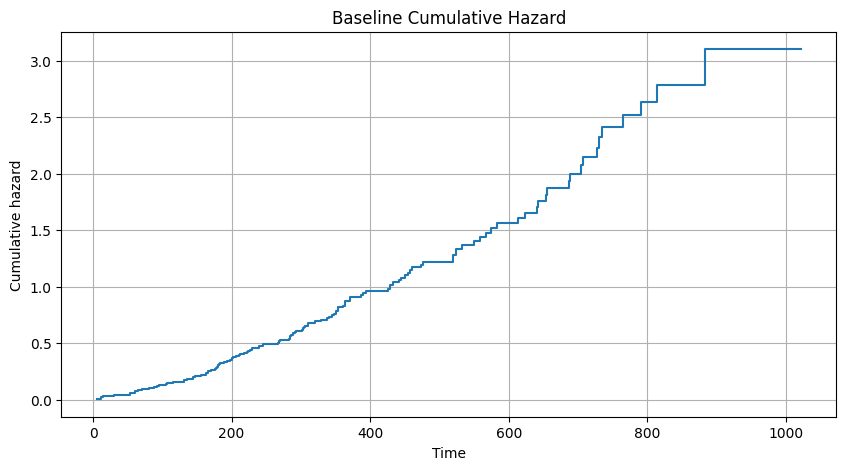

In [ ]:
# --- BASELINE HAZARD ---
plt.figure(figsize=(10, 5))
plt.step(
    cph.baseline_hazard_.index,
    cph.baseline_hazard_.values.flatten(),
    where="post"
)
plt.title("Baseline Hazard")
plt.xlabel("Time")
plt.ylabel("Baseline hazard")
plt.grid(True)
plt.show()

# --- BASELINE CUMULATIVE HAZARD ---
plt.figure(figsize=(10, 5))
plt.step(
    cph.baseline_cumulative_hazard_.index,
    cph.baseline_cumulative_hazard_.values.flatten(),
    where="post"
)
plt.title("Baseline Cumulative Hazard")
plt.xlabel("Time")
plt.ylabel("Cumulative hazard")
plt.grid(True)
plt.show()


## Concordance Index (C-Index)

It is a performance measure that generalizes AUC for survival analysis. It measures the proportion of all pairs of individuals where the predictions are concordant with the actual outcomes

$$C = \frac{\text{Number of concordant pairs}}{\text{Number of comparable pairs}}$$

that is computed as

$$ C = \frac{\sum_{i}\sum_{j} \mathbb{I}\left( (T_i < T_j \land \eta_i > \eta_j) \lor (T_i > T_j \land \eta_i < \eta_j) \lor (T_i = T_j \land \eta_i = \eta_j) \right)}{\text{Number of comparable pairs}}
$$

where $\eta_i$ is the risk score produced by the model for patient i. In a Cox model it corresponds to $X_i^T \beta$








## Cross-validation

In [ ]:
from lifelines.utils import k_fold_cross_validation

In [ ]:
scores = k_fold_cross_validation(cph, df_enc, 'time', event_col='status', k=10, scoring_method="concordance_index", seed=1234)

In [ ]:
scores

[np.float64(0.7368421052631579),
 np.float64(0.48),
 np.float64(0.7817258883248731),
 np.float64(0.6172248803827751),
 np.float64(0.6403940886699507),
 np.float64(0.465),
 np.float64(0.6421568627450981),
 np.float64(0.6894736842105263),
 np.float64(0.5454545454545454),
 np.float64(0.58125)]

In [ ]:
print(np.mean(scores), np.std(scores))

0.6179522055050927 0.0980765684010751


## Prediction

In [ ]:
X = df_enc

The partial hazard for a given patient $X_i$ is $exp(X_i^T \beta)$. It is a risk score that can be used to compare different patients

In [ ]:
cph.predict_partial_hazard(X)

,0
0,1.31
1,0.67
2,0.60
3,1.97
4,0.89
...,...
223,2.19
224,0.54
225,1.27
226,1.32


$$
\hat{H}(t \mid X)
= \hat{H}_0(t)\,\exp\!\left( X^\top \hat\beta \right).
$$


In [ ]:
cph.predict_cumulative_hazard(X)

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
5.00,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.01,...,0.01,0.00,0.00,0.00,0.01,0.01,0.00,0.01,0.01,0.00
11.00,0.02,0.01,0.01,0.03,0.01,0.01,0.03,0.02,0.01,0.04,...,0.05,0.00,0.02,0.01,0.03,0.04,0.01,0.02,0.02,0.01
12.00,0.03,0.01,0.01,0.04,0.02,0.02,0.03,0.02,0.02,0.05,...,0.06,0.01,0.02,0.01,0.03,0.04,0.01,0.03,0.03,0.01
13.00,0.04,0.02,0.02,0.06,0.03,0.03,0.05,0.03,0.03,0.07,...,0.09,0.01,0.03,0.02,0.05,0.06,0.02,0.04,0.04,0.02
15.00,0.04,0.02,0.02,0.06,0.03,0.03,0.06,0.04,0.03,0.08,...,0.10,0.01,0.04,0.02,0.05,0.07,0.02,0.04,0.04,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840.00,3.75,1.92,1.73,5.65,2.56,2.60,4.89,3.27,2.62,6.56,...,8.56,0.84,3.45,1.83,4.73,6.27,1.54,3.65,3.78,1.59
883.00,4.20,2.15,1.94,6.34,2.87,2.92,5.48,3.66,2.94,7.35,...,9.59,0.94,3.86,2.06,5.30,7.03,1.72,4.09,4.24,1.79
965.00,4.20,2.15,1.94,6.34,2.87,2.92,5.48,3.66,2.94,7.35,...,9.59,0.94,3.86,2.06,5.30,7.03,1.72,4.09,4.24,1.79
1010.00,4.20,2.15,1.94,6.34,2.87,2.92,5.48,3.66,2.94,7.35,...,9.59,0.94,3.86,2.06,5.30,7.03,1.72,4.09,4.24,1.79


NB: Both the predicted cumulative hazard function and the predicted survival function return a dataframe with patients on the columns and time on the rows

Remember the link between survival and (cumulative) hazard functions:

$$ H(t) = - log(S(t))$$

and so

$$
\widehat{S}(t \mid X)
= \exp\!\left( -\,\hat{H}_0(t)\,\exp\!\left( X^\top \hat\beta \right) \right),
$$


In [ ]:
cph.predict_survival_function(X)

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
5.00,0.99,1.00,1.00,0.99,1.00,1.00,0.99,1.00,1.00,0.99,...,0.99,1.00,1.00,1.00,0.99,0.99,1.00,0.99,0.99,1.00
11.00,0.98,0.99,0.99,0.97,0.99,0.99,0.97,0.98,0.99,0.96,...,0.95,1.00,0.98,0.99,0.97,0.97,0.99,0.98,0.98,0.99
12.00,0.97,0.99,0.99,0.96,0.98,0.98,0.97,0.98,0.98,0.95,...,0.94,0.99,0.98,0.99,0.97,0.96,0.99,0.97,0.97,0.99
13.00,0.96,0.98,0.98,0.95,0.97,0.97,0.95,0.97,0.97,0.94,...,0.92,0.99,0.97,0.98,0.95,0.94,0.98,0.96,0.96,0.98
15.00,0.96,0.98,0.98,0.94,0.97,0.97,0.95,0.96,0.97,0.93,...,0.91,0.99,0.96,0.98,0.95,0.93,0.98,0.96,0.96,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840.00,0.02,0.15,0.18,0.00,0.08,0.07,0.01,0.04,0.07,0.00,...,0.00,0.43,0.03,0.16,0.01,0.00,0.22,0.03,0.02,0.20
883.00,0.01,0.12,0.14,0.00,0.06,0.05,0.00,0.03,0.05,0.00,...,0.00,0.39,0.02,0.13,0.00,0.00,0.18,0.02,0.01,0.17
965.00,0.01,0.12,0.14,0.00,0.06,0.05,0.00,0.03,0.05,0.00,...,0.00,0.39,0.02,0.13,0.00,0.00,0.18,0.02,0.01,0.17
1010.00,0.01,0.12,0.14,0.00,0.06,0.05,0.00,0.03,0.05,0.00,...,0.00,0.39,0.02,0.13,0.00,0.00,0.18,0.02,0.01,0.17


<Axes: >

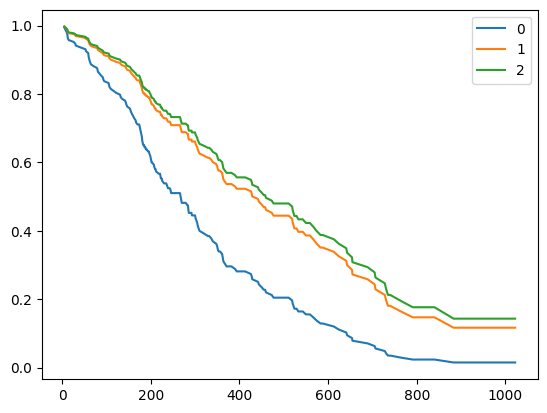

In [ ]:
cph.predict_survival_function(X.iloc[0:3]).plot()

In [ ]:
cph.predict_median(X)

,0.50
0,268.00
1,442.00
2,460.00
3,197.00
4,348.00
...,...
223,182.00
224,524.00
225,269.00
226,268.00


## Feature selection

We can fit a Cox model also with scikit-survival :

In [ ]:
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold

In [ ]:
time_col = "time"
event_col = "status"
covariates = [c for c in df_enc.columns if c not in [time_col, event_col]]

# covariates = [c for c in covariates if c != 'ph.ecog_3.0']

# covariates = [c for c in covariates if not c.startswith('inst')]

X = df_enc[covariates]
y = Surv.from_dataframe(event_col, time_col, df_enc)

cox = CoxPHSurvivalAnalysis()

In [ ]:
covariates

['age',
 'ph.karno',
 'pat.karno',
 'meal.cal',
 'wt.loss',
 'ph.ecog_1.0',
 'ph.ecog_2.0',
 'sex_Male']

In [ ]:
cox.fit(X, y)

CoxPHSurvivalAnalysis()

In [ ]:
cox.score(X, y) # c-index on training data

np.float64(0.647329324372126)

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
print(f"Mean concordance index: {np.mean(scores):.4f}")
print(f"Standard deviation of concordance index: {np.std(scores):.4f}")

Mean concordance index: 0.6180
Standard deviation of concordance index: 0.0981


## Forward

In [ ]:
sfs_forward = SequentialFeatureSelector(
    estimator=cox,
    n_features_to_select="auto",
    direction="forward",
    cv=cv,
)

sfs_forward.fit(X, y)

selected_forward = X.columns[sfs_forward.get_support()].tolist()
print("Forward selection:", selected_forward)


Forward selection: ['pat.karno', 'meal.cal', 'ph.ecog_2.0', 'sex_Male']


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores_forward = cross_val_score(
    CoxPHSurvivalAnalysis(),
    X[selected_forward],
    y,
    cv=cv,
)
print("Forward selection - CV c-index: ",
      f"{cv_scores_forward.mean():.4f} ± {cv_scores_forward.std():.4f}")

Forward selection - CV c-index:  0.6564 ± 0.0564


## Backward

In [ ]:
sfs_backward = SequentialFeatureSelector(
    estimator=cox,
    n_features_to_select="auto",
    direction="backward",
    cv=cv,
)

sfs_backward.fit(X, y)

selected_backward = X.columns[sfs_backward.get_support()].tolist()
print("Backward selection:", selected_backward)

Backward selection: ['pat.karno', 'meal.cal', 'ph.ecog_2.0', 'sex_Male']


In [ ]:
cv_scores_backward = cross_val_score(
    CoxPHSurvivalAnalysis(),
    X[selected_backward],
    y,
    cv=cv,
)
print("Backward selection - CV c-index: ",
      f"{cv_scores_backward.mean():.4f} ± {cv_scores_backward.std():.4f}")

Backward selection - CV c-index:  0.6564 ± 0.0564


## Best subset

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

efs = EFS(
    estimator=cox,
    min_features=2,
    max_features=4, # to speed up, otherwise len(covariates)
    scoring=lambda est, X_sub, y_sub: est.score(X_sub, y_sub),
    cv=cv,
    print_progress=True,
)

efs = efs.fit(X, y)

best_idx = list(efs.best_idx_) # indexes of the selected features
best_subset = [covariates[i] for i in best_idx]

print("Best subset:", best_subset)
print("Best CV c-index:", efs.best_score_)

Features: 154/154

Best subset: ['pat.karno', 'meal.cal', 'ph.ecog_2.0', 'sex_Male']
Best CV c-index: 0.6563779119804787


## Penalization

Cox models support L1 and L2 penalizations:

$$ \beta = arg \max_{\beta} \{log(L(\beta)) - \alpha(\lambda \sum_{j=1}^p |\beta_j| + (1-\lambda)\sum_{j=1}^p\beta_j^2) \}$$

In [ ]:
cph = CoxPHFitter(penalizer=0.1, l1_ratio=1.0) # penalizer is alpha, l1_ratio is lambda in the equation above
cph.fit(df_enc, duration_col = 'time', event_col = 'status')

<lifelines.CoxPHFitter: fitted with 227 total observations, 63 right-censored observations>

In [ ]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 227 total observations, 63 right-censored observations>
             duration col = 'time'
                event col = 'status'
                penalizer = 0.1
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 227
number of events observed = 164
   partial log-likelihood = -741.71
         time fit was run = 2025-11-25 10:21:38 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
age          0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ph.karno    -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
pat.karno   -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
meal.cal    -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
wt.loss     -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ph.ecog_1.0  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ph.ecog_2.0  0.25      1.28      0.24           -0.22            0.71                0.80                2.03
sex_Male     0.22      1.25      0.16           -0.09            0.54                0.91                1.71

             cmp to     z    p  -log2(p)
covariate                               
age            0.00  0.00 1.00      0.00
ph.karno       0.00 -0.00 1.00      0.00
pat.karno      0.00 -0.73 0.47      1.10
meal.cal       0.00 -0.00 1.00      0.00
wt.loss        0.00 -0.00 1.00      0.00
ph.ecog_1.0    0.00  0.00 1.00      0.00
ph.ecog_2.0    0.00  1.04 0.30      1.74
sex_Male       0.00  1.40 0.16      2.63
---
Concordance = 0.66
Partial AIC = 1499.41
log-likelihood ratio test = 5.57 on 8 df
-log2(p) of ll-ratio test = 0.52

## Check assumptions

Cox model has a strong assumption: the proportional hazard assumption.

This assumption states that the hazard ratio between two individuals i and j is a constant, i.e. it does not change over time:

$$ HR_{i,j} = \frac{h_i(t)}{h_j(t)} = \frac{h_0(t)exp(X_i^T \beta)}{h_0(t)exp(X_j^T \beta)} = \frac{exp(X_i^T \beta)}{exp(X_j^T \beta)} = \text{c} $$

There are multiple ways to try to assess if this assumption holds



### Schoenfeld's residuals and test

Statistical test for time varying coefficients:

$$H_0: \text{the coefficient is not time varying} $$

In [ ]:
cph.check_assumptions(df_enc, p_value_threshold = 0.05)

Proportional hazard assumption looks okay.


[]

We can include the plot of the Schoenfeld residuals

$$s_{j}(t) = \beta_j(t) - \hat{\beta_j}$$


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.9995)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9998)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9982)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9980)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1425)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1139)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9984)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9983)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9994)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9994)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9997)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9998)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5625)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6542)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1142)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1038)'>]]

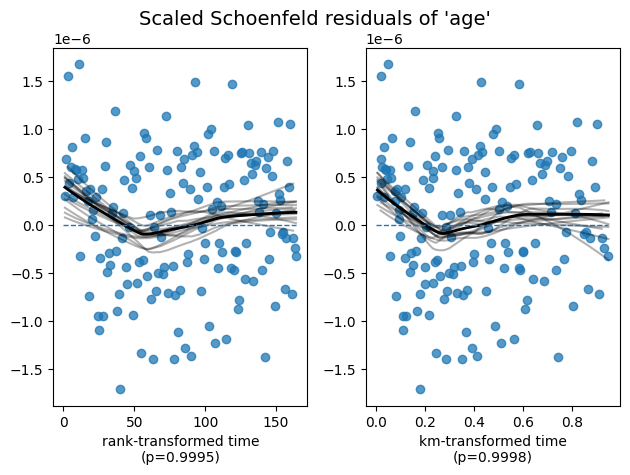

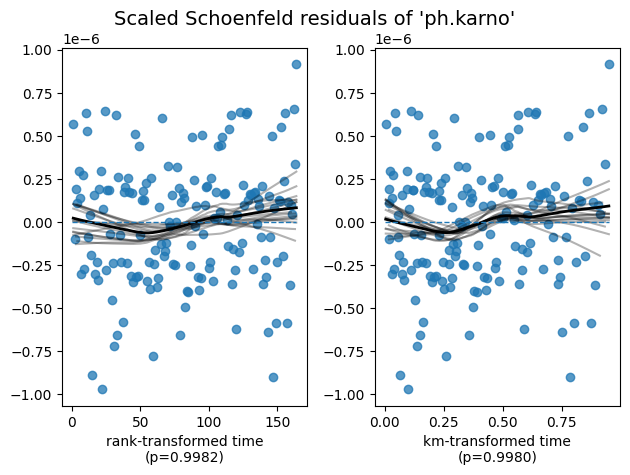

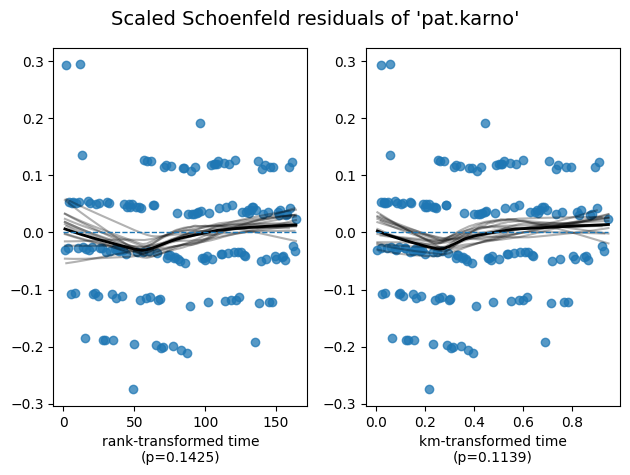

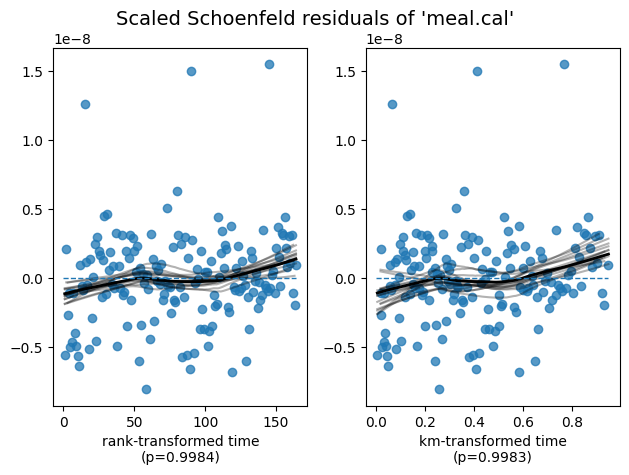

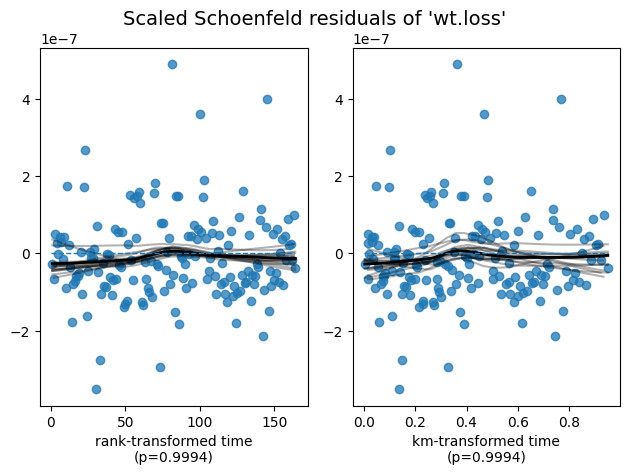

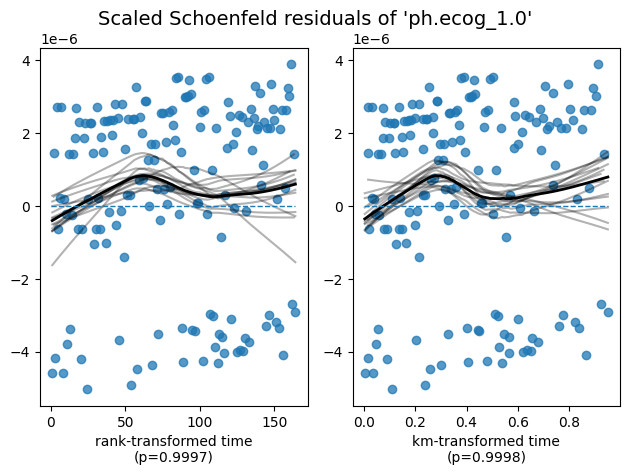

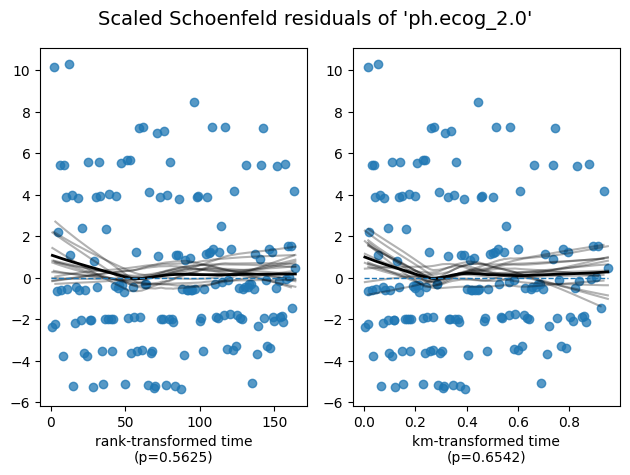

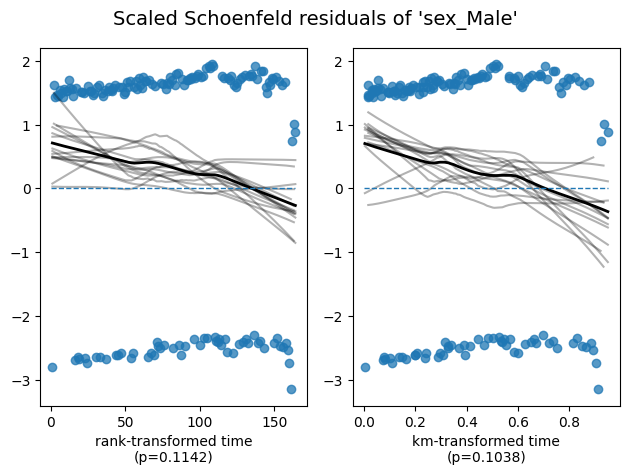

In [ ]:
cph.check_assumptions(df_enc, p_value_threshold = 0.05, show_plots=True)

A non-flat plot might indicate a violation of PH assumption, especially if combined with a low p-value of the test

### Martingale and deviance residuals

$$ M_i = \delta_i - \hat{H}(X_i, t_i, \hat{\beta}) $$

with $\delta_i$ being 1 if the subject experienced the event or 0 if he was censored

In [ ]:
mr = cph.compute_residuals(df_enc, 'martingale')
mr.head()

,time,status,martingale
56,5.00,True,1.00
72,11.00,True,0.98
78,11.00,True,0.98
107,11.00,True,0.98
29,12.00,True,0.97


In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess as lowess

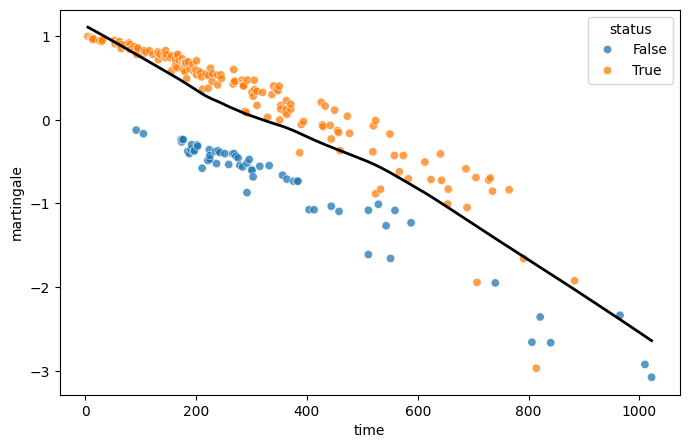

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=mr,
    x='time', y='martingale', hue='status',
    alpha=0.75,
    ax=ax
)
y_lowess = lowess(mr.martingale.values, mr.time.values, return_sorted=False)
ax.plot(mr.time.values, y_lowess, color="k", alpha=1.0, linewidth=2)
plt.show()

In [ ]:
dr = cph.compute_residuals(df_enc, 'deviance')
dr.head()

,time,status,deviance
56,5.00,True,3.05
72,11.00,True,2.41
78,11.00,True,2.46
107,11.00,True,2.48
29,12.00,True,2.20


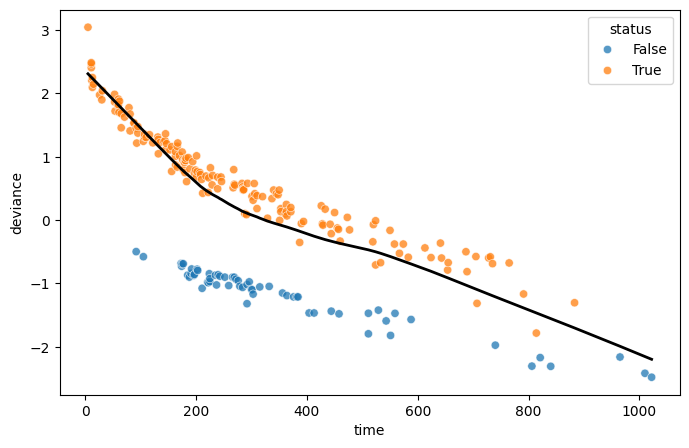

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=dr,
    x='time', y='deviance', hue='status',
    alpha=0.75,
    ax=ax
)
y_lowess = lowess(dr.deviance.values, dr.time.values, return_sorted=False)
ax.plot(dr.time.values, y_lowess, color="k", alpha=1.0, linewidth=2, zorder=2)
plt.show()

### Log-log KM

<Axes: xlabel='log(timeline)', ylabel='log(-log(survival_function_))'>

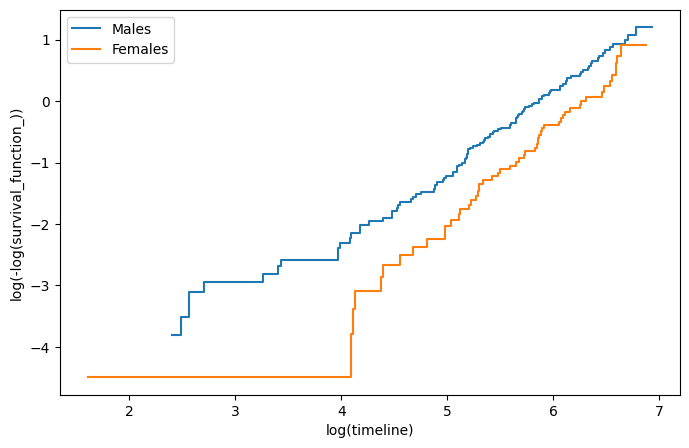

In [ ]:
from lifelines.plotting import loglogs_plot

kmf = KaplanMeierFitter()

males = (df["sex"] == "Male")

kmf.fit(df.loc[males]['time'], event_observed=df.loc[males]['status'], label="Males")

fig, ax = plt.subplots(figsize=(8,5))

loglogs_plot(kmf, ax=ax)

kmf.fit(df.loc[~males]['time'], event_observed=df.loc[~males]['status'], label="Females")

loglogs_plot(kmf, ax=ax)

<Axes: xlabel='log(timeline)', ylabel='log(-log(survival_function_))'>

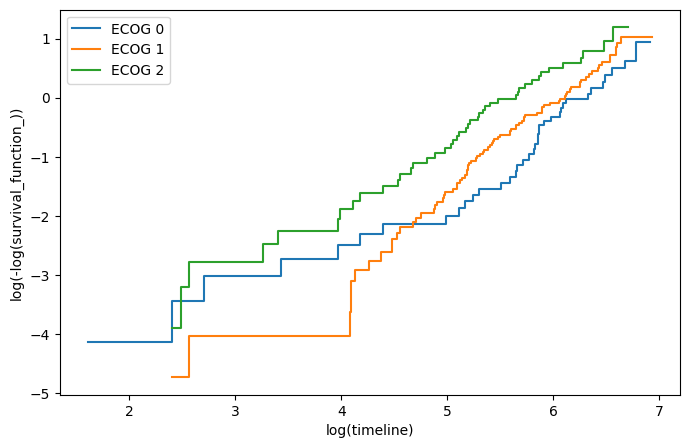

In [ ]:
from lifelines.plotting import loglogs_plot

kmf = KaplanMeierFitter()

ecog0 = df['ph.ecog'] == 0
ecog1 = df['ph.ecog'] == 1
ecog2 = df['ph.ecog'] == 2

fig, ax = plt.subplots(figsize=(8,5))

kmf.fit(df.loc[ecog0]['time'], event_observed=df.loc[ecog0]['status'], label="ECOG 0")
loglogs_plot(kmf, ax=ax)

kmf.fit(df.loc[ecog1]['time'], event_observed=df.loc[ecog1]['status'], label="ECOG 1")
loglogs_plot(kmf, ax=ax)

kmf.fit(df.loc[ecog2]['time'], event_observed=df.loc[ecog2]['status'], label="ECOG 2")
loglogs_plot(kmf, ax=ax)

### Stratifty w.r.t one variable

In [ ]:
df_enc_2 = pd.get_dummies(df, columns=['sex', 'ph.ecog'], dtype=int, drop_first=True)

In [ ]:
df_enc_2 = df_enc_2[df_enc_2['ph.ecog_3.0']==0]
df_enc_2.drop('ph.ecog_3.0', axis=1, inplace=True)

KeyError: 'ph.ecog_3.0'

In [ ]:
strata_col = 'meal.cal'

In [ ]:
df[strata_col].describe()

In [ ]:
bin_size = 600
bin_edges = np.arange(df_enc_2[strata_col].min()-bin_size, df_enc_2[strata_col].max() + bin_size, bin_size)

In [ ]:
df_enc_2[strata_col + '_strata'] = pd.cut(df_enc_2[strata_col], bin_edges)
print(df_enc_2[strata_col + '_strata'].isna().sum())

In [ ]:
print(df_enc_2[strata_col+ '_strata'].value_counts())

In [ ]:
#df_enc_2 = df_enc_2.drop(strata_col, axis=1)

In [ ]:
cph.fit(df_enc_2, duration_col = 'time', event_col = 'status', strata=['inst'])
cph.print_summary()

In [ ]:
cph.check_assumptions(df_enc_2, p_value_threshold = 0.05, show_plots=True)

# Another dataset

In [ ]:
from lifelines.datasets import load_gbsg2
df = load_gbsg2()

In [ ]:
df

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1
...,...,...,...,...,...,...,...,...,...,...
681,no,49,Pre,30,III,3,1,84,721,0
682,yes,53,Post,25,III,17,0,0,186,0
683,no,51,Pre,25,III,5,43,0,769,1
684,no,52,Post,23,II,3,15,34,727,1


In [ ]:
df['death'] = df['cens'].apply(lambda x: not x)

In [ ]:
df.drop('cens', axis=1, inplace=True)

In [ ]:
df.isna().sum()

,0
horTh,0
age,0
menostat,0
tsize,0
tgrade,0
pnodes,0
progrec,0
estrec,0
time,0
death,0


In [ ]:
df_enc = pd.get_dummies(df, dtype=int, drop_first=True)